# How to Use Tensorboard with PyTorch

In [1]:
# import libraries
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter
#writer = SummaryWriter()
writer = SummaryWriter('runs/mnist_tboard')

import warnings
warnings.filterwarnings('ignore')

2022-02-18 23:18:01.733157: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [2]:
train_data = dsets.MNIST(root='mnist_data/', train=True,transform = transforms.ToTensor(), download=True)
test_data = dsets.MNIST(root='mnist_data/', train=False, transform = transforms.ToTensor(),download=True)

In [3]:
batch_size = 16
train_loader = torch.utils.data.DataLoader(dataset=train_data,\
                                          batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_data,\
                                          batch_size=batch_size)

In [4]:
# size of the data
print(train_data.train_data.size())
print(train_data.train_labels.size())

torch.Size([60000, 28, 28])
torch.Size([60000])


In [5]:
digit_numpy = {0: torch.unsqueeze(train_data.train_data[1], dim=0),\
               1:torch.unsqueeze(train_data.train_data[24], dim=0),\
               2:torch.unsqueeze(train_data.train_data[5], dim=0),\
               3:torch.unsqueeze(train_data.train_data[7], dim=0),\
               4:torch.unsqueeze(train_data.train_data[2], dim=0),\
               5:torch.unsqueeze(train_data.train_data[0], dim=0),\
               6:torch.unsqueeze(train_data.train_data[13], dim=0),\
               7:torch.unsqueeze(train_data.train_data[15], dim=0),\
               8:torch.unsqueeze(train_data.train_data[17], dim=0),\
               9:torch.unsqueeze(train_data.train_data[4], dim=0)}

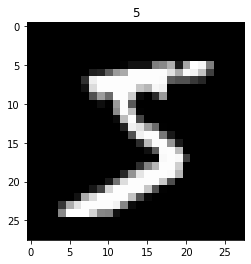

In [6]:
# plot one example
plt.imshow(train_data.train_data[0].numpy(), cmap='gray')
plt.title(f'{train_data.train_labels[0]}');

In [7]:
# image on tensorboard
sample = iter(train_loader)
sample_data, sample_targets = sample.next()
img_grid = torchvision.utils.make_grid(sample_data)
writer.add_image('sample_images', img_grid)

In [8]:
class MnistNet(nn.Module):
    def __init__(self):
        super(MnistNet, self).__init__()
        self.linear1 = nn.Linear(28*28, 64)
        self.linear2 = nn.Linear(64, 10)
        
    def forward(self, x):
        linear1 = F.relu(self.linear1(x))
        out = self.linear2(linear1)
        return out

In [9]:
model = MnistNet()
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model#.to(device)

MnistNet(
  (linear1): Linear(in_features=784, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=10, bias=True)
)

In [10]:
# define the loss function
loss_function = nn.CrossEntropyLoss()

In [11]:
# define the optimization
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [20]:
# train the model
epoch = 1
# training and testing
for epch in range(epoch):  # loop over the dataset multiple times
    running_loss = 0.0 # running loss
    for step,  (x, y) in enumerate(train_loader):
        inputs, labels = x.reshape(-1, 28*28), y#.to(device), y.to(device) # reshape
        outputs = model(inputs) 
        optimizer.zero_grad()
        loss = loss_function(outputs, labels)
        
        loss.backward() # backpropagation
        optimizer.step()
        
        val_pred = torch.max(outputs.data, 1)
        inx = torch.where(labels != val_pred[1], 10, labels)
        fls_inx = [i for i in range(len(inx)) if inx[i]==10]
        if fls_inx != []:
            tr_imgs = torchvision.utils.make_grid([x[i] for i in fls_inx])
            fls_imgs = torchvision.utils.make_grid([digit_numpy[val_pred[1][i].item()] for i in fls_inx])
            writer.add_image('False Predicted', fls_imgs, global_step=step)
            writer.add_image('True Labels',  tr_imgs, global_step=step)
        if (step+1) % 1024 == 0:    # print every 1024 mini-batches
            print (f'Epoch [{epch+1}/{epoch}], Step [{step+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            writer.add_scalar('Training loss', loss, global_step=step)
            running_loss = 0.0
print('Finished Training')

Epoch [1/1], Step [1024/3750], Loss: 0.1547
Epoch [1/1], Step [2048/3750], Loss: 0.0051
Epoch [1/1], Step [3072/3750], Loss: 0.0031
Finished Training


In [21]:
# build a confusion matrix

y_pred = []
y_true = []
# constant for classes
classes = ('0', '1', '2', '3', '4',
        '5', '6', '7', '8', '9')
plt.figure(figsize = (16, 10))

i = 0
# iterate over test data
for inputs, labels in test_loader:
    inputs = inputs.reshape(-1, 28*28)
    output = model(inputs)
    val_pred = torch.max(outputs.data, 1)
    y_pred.extend(val_pred[1].numpy()) 

    labels = labels.numpy()
    y_true.extend(labels) 

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])
writer.add_figure('Confusion Matrix', sns.heatmap(df_cm, annot=True).get_figure())

In [22]:
# the confusion matrix
df_cm

,0,1,2,3,4,5,6,7,8,9
0,52,122,65,131,113,164,73,54,77,129
1,87,135,74,125,145,220,71,70,85,123
2,57,137,55,142,128,192,60,70,71,120
3,62,124,74,140,128,178,53,71,57,123
4,67,127,44,126,131,174,61,74,55,123
5,57,108,68,107,95,186,63,56,39,113
6,58,119,72,122,115,179,69,50,55,119
7,58,121,65,130,132,208,49,71,54,140
8,61,137,56,102,111,184,68,65,68,122
9,66,120,52,125,152,190,58,44,64,138


In [23]:
total = sum([df_cm[str(i)].sum() for i in range(10)])
false_pos = sum([(df_cm[str(i)].sum()-df_cm[str(i)][i]) for i in range(10)])
true_pos = sum(df_cm[str(i)][str(i)] for i in range(10))
false_neg = sum([(df_cm.iloc[i].sum()- df_cm.iloc[i][i]) for i in range(10)])

In [24]:
# Accuracy
accuracy = true_pos/total

# Precision
precision = true_pos/(true_pos+false_pos)

# Recall
recall = true_pos/(true_pos+false_neg)

# F1 Score
f1_score = 2*((precision*recall)/(precision+recall))

In [25]:
# create a dataframe for the metrics measurment
metric = {'Accuracy':accuracy, 'Precision':precision, 'Recall':recall, 'F1 Score':f1_score}
metric_df = pd.DataFrame(metric, index = [0], columns=metric.keys())

In [26]:
# write it as a text to the tensorboard
writer.add_text("Mertics dataframe", \
                f"Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}, F1 Score: {f1_score}")

In [27]:
# show the tensorboard in localhost
!tensorboard --logdir='runs/mnist_tboard/'

2022-02-18 23:20:38.134572: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.8.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
